In [3]:
if (!requireNamespace("softImpute", quietly = TRUE)) {
  install.packages("softImpute")
}
if (!requireNamespace("fastDummies", quietly = TRUE)) {
  install.packages("fastDummies")
}
library(softImpute)
library(fastDummies)

## Read Files

In [4]:
physical_train <- read.csv('../../data/physical_attributes.csv', check.names = FALSE)
train <- read.csv('../../data/train.csv', check.names = FALSE)
test <- read.csv('../../data/test.csv', check.names = FALSE)
data_dict <- read.csv('../../data/data_dictionary.csv', check.names = FALSE)

head(train)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>
1,00008ff9,Fall,5,0,Winter,51,Fall,16.87732,46.0,50.8,...,4,2,4,55,,NA,NA,Fall,3,2
2,000fd460,Summer,9,0,,NA,Fall,14.03559,48.0,46.0,...,0,0,0,0,Fall,46,64,Summer,0,0
3,00105258,Summer,10,1,Fall,71,Fall,16.64870,56.5,75.6,...,2,1,1,28,Fall,38,54,Summer,2,0
4,00115b9f,Winter,9,0,Fall,71,Summer,18.29235,56.0,81.6,...,3,4,1,44,Summer,31,45,Winter,0,1
5,0016bb22,Spring,18,1,Summer,NA,,NA,NA,NA,...,NA,NA,NA,NA,,NA,NA,,NA,NA
6,001f3379,Spring,13,1,Winter,50,Summer,22.27995,59.5,112.2,...,1,2,1,34,Summer,40,56,Spring,0,1


In [10]:
head(physical_train)

,id,Basic_Demos-Age,Basic_Demos-Sex,fixed-Physical-BMI,fixed_Weight,diastolic_bp,systolic_bp,heart_rate
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00008ff9,5,0,16.87732,50.8,NA,NA,NA
2,000fd460,9,0,14.03559,46.0,75,122,70
3,00105258,10,1,16.64870,75.6,65,117,94
4,00115b9f,9,0,18.29235,81.6,60,117,97
5,001f3379,13,1,22.27995,112.2,60,102,73
6,0038ba98,10,0,19.66076,84.6,NA,NA,83


## Prepare Data

In [5]:
# Remove categorical data
cat_c <- c('Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
           'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season',
           'PreInt_EduHx-Season', 'Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
           'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
           'BIA-BIA_Frame_num')

id_col <- c('id')

pciat <- grep("^PCIAT-PCIAT", names(train), value = TRUE)
pciat_and_pred <- c(pciat, "sii", "PCIAT-Season")

columns_float <- setdiff(names(train), cat_c)
columns_float <- setdiff(columns_float, id_col)
columns_float <- setdiff(columns_float, pciat_and_pred)
print(columns_float)

 [1] "Basic_Demos-Age"                       
 [2] "CGAS-CGAS_Score"                       
 [3] "Physical-BMI"                          
 [4] "Physical-Height"                       
 [5] "Physical-Weight"                       
 [6] "Physical-Waist_Circumference"          
 [7] "Physical-Diastolic_BP"                 
 [8] "Physical-HeartRate"                    
 [9] "Physical-Systolic_BP"                  
[10] "Fitness_Endurance-Max_Stage"           
[11] "Fitness_Endurance-Time_Mins"           
[12] "Fitness_Endurance-Time_Sec"            
[13] "FGC-FGC_CU"                            
[14] "FGC-FGC_GSND"                          
[15] "FGC-FGC_GSD"                           
[16] "FGC-FGC_PU"                            
[17] "FGC-FGC_SRL"                           
[18] "FGC-FGC_SRR"                           
[19] "FGC-FGC_TL"                            
[20] "BIA-BIA_BMC"                           
[21] "BIA-BIA_BMI"                           
[22] "BIA-BIA_BMR"                

In [6]:
train_filtered_float = train[columns_float]
train_filtered_cat = train[cat_c]
train_filtered_float[] <- lapply(train_filtered_float, function(x) as.numeric(as.character(x)))
train_filtered_cat[] <- lapply(train_filtered_cat, as.factor)
train_filtered_float <- as.data.frame(train_filtered_float)
train_filtered_cat <- as.data.frame(train_filtered_cat)
train_matrix_float <- as.matrix(train_filtered_float)
train_matrix_cat <- as.matrix(train_filtered_cat)

In [7]:
sii_columns <- grep("sii", colnames(train_filtered_float), value = TRUE)
pciat_columns <- grep("%PCIAT%", colnames(train_filtered_float), value = TRUE)
print(sii_columns)
print(pciat_columns)

character(0)
character(0)


In [8]:
sii_columns <- grep("sii", colnames(train_filtered_cat), value = TRUE)
pciat_columns <- grep("%PCIAT%", colnames(train_filtered_cat), value = TRUE)
print(sii_columns)
print(pciat_columns)

character(0)
character(0)


## Categorical Mode Impute

In [9]:
calculate_mode <- function(x) {
  tbl <- table(x)
  mode_val <- names(tbl)[which.max(tbl)]
  return(mode_val)
}

train_filtered_cat[] <- lapply(train_filtered_cat, function(x) {
  mode_val <- calculate_mode(x) 
  x[is.na(x)] <- mode_val 
  return(x)
})

In [10]:
anyNA(train_filtered_cat)

[1] FALSE

## Float Mean Impute

In [11]:
calculate_mean <- function(x) {
  mean_val <- mean(x, na.rm = TRUE)
  return(mean_val)
}

train_filtered_float <- lapply(train_filtered_float, function(x) {
  if (is.numeric(x)) { 
    mean_val <- calculate_mean(x)
    x[is.na(x)] <- mean_val
  }
  return(x)
})

train_filtered_float <- as.data.frame(train_filtered_float)
anyNA(train_filtered_float)

[1] FALSE

In [12]:
final_data <- cbind(train['id'], train_filtered_float, train_filtered_cat)
final_data <- cbind(final_data, train[pciat_and_pred])

In [13]:
write.csv(final_data, "../training_sets/imputed_train_mean_and_mode_impute.csv", row.names = FALSE, col.names = TRUE)

Warning message in write.csv(final_data, "../training_sets/imputed_train_mean_and_mode_impute.csv", :
"attempt to set 'col.names' ignored"


## Train Test Impute for Float Data

In [51]:
set.seed(1)
original_train_matrix_float <- train_matrix_float
missing_indices <- sample(length(train_matrix_float), size = 0.2 * length(train_matrix_float), replace = FALSE)
train_matrix_float[missing_indices] <- NA

In [53]:
lambdas <- seq(0, 20, by = 1)
ranks <- seq(1, 6, by = 1) 

results <- expand.grid(rank = ranks, lambda = lambdas, RMSE = NA)

for (i in seq_len(nrow(results))) {
  rank <- results$rank[i]
  lambda <- results$lambda[i]

  rank <- min(nrow(train_matrix_float), ncol(train_matrix_float), rank)
  
  fit <- softImpute(train_matrix_float, rank.max = rank, lambda = lambda, type = c("als", "svd"))
  
  imputed_matrix <- complete(train_matrix_float, fit)
  
  results$RMSE[i] <- sqrt(mean((original_train_matrix_float[missing_indices] - imputed_matrix[missing_indices])^2, na.rm = TRUE))
}

best_row <- results[which.min(results$RMSE), ]
best_rank <- best_row$rank
best_lambda <- best_row$lambda
cat("Best Rank:", best_rank, "\nBest Lambda:", best_lambda, "\nBest RMSE:", best_row$RMSE, "\n")

Best Rank: 1 
Best Lambda: 3 
Best RMSE: 208.4703 


In [54]:
final_fit <- softImpute(train_matrix_float, rank.max = best_rank, lambda = best_lambda)
imputed_data <- complete(train_matrix_float, final_fit)

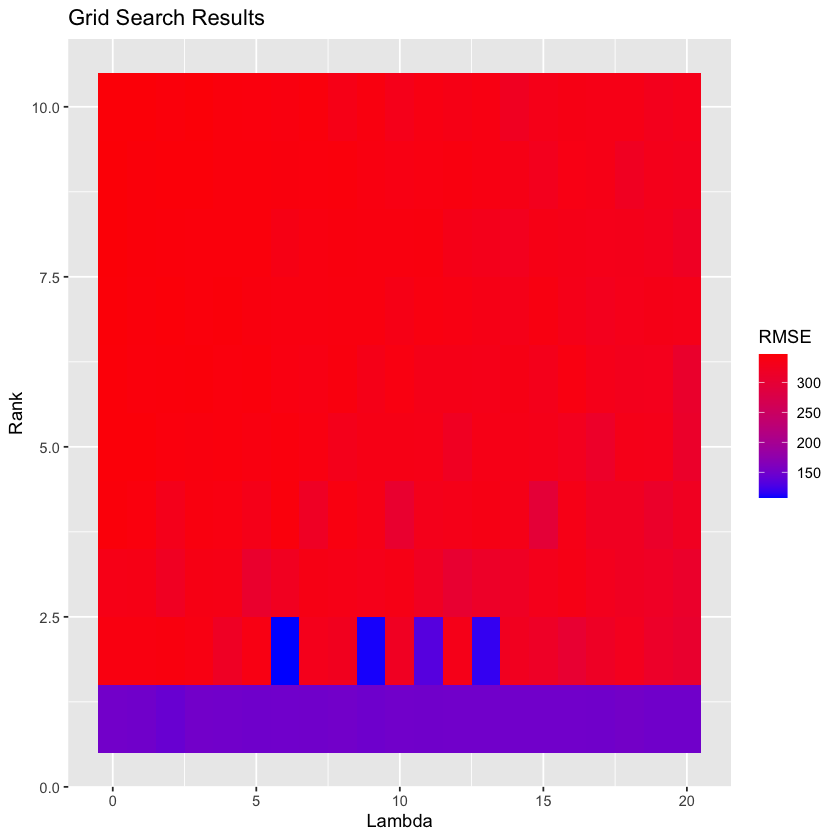

In [459]:
library(ggplot2)

ggplot(results, aes(x = lambda, y = rank, fill = RMSE)) +
  geom_tile() +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "Grid Search Results", x = "Lambda", y = "Rank", fill = "RMSE")


In [55]:
final_data <- cbind(train['id'], imputed_data, train_filtered_cat)
final_data <- cbind(final_data, train[pciat_and_pred])

In [61]:
names(final_data)

[1] "id"                                    
 [2] "Basic_Demos-Age"                       
 [3] "CGAS-CGAS_Score"                       
 [4] "Physical-BMI"                          
 [5] "Physical-Height"                       
 [6] "Physical-Weight"                       
 [7] "Physical-Waist_Circumference"          
 [8] "Physical-Diastolic_BP"                 
 [9] "Physical-HeartRate"                    
[10] "Physical-Systolic_BP"                  
[11] "Fitness_Endurance-Max_Stage"           
[12] "Fitness_Endurance-Time_Mins"           
[13] "Fitness_Endurance-Time_Sec"            
[14] "FGC-FGC_CU"                            
[15] "FGC-FGC_GSND"                          
[16] "FGC-FGC_GSD"                           
[17] "FGC-FGC_PU"                            
[18] "FGC-FGC_SRL"                           
[19] "FGC-FGC_SRR"                           
[20] "FGC-FGC_TL"                            
[21] "BIA-BIA_BMC"                           
[22] "BIA-BIA_BMI"                           
[23] "BIA-BIA_BMR"                           
[24] "BIA-BIA_DEE"                           
[25] "BIA-BIA_ECW"                           
[26] "BIA-BIA_FFM"                           
[27] "BIA-BIA_FFMI"                          
[28] "BIA-BIA_FMI"                           
[29] "BIA-BIA_Fat"                           
[30] "BIA-BIA_ICW"                           
[31] "BIA-BIA_LDM"                           
[32] "BIA-BIA_LST"                           
[33] "BIA-BIA_SMM"                           
[34] "BIA-BIA_TBW"                           
[35] "PAQ_A-PAQ_A_Total"                     
[36] "PAQ_C-PAQ_C_Total"                     
[37] "SDS-SDS_Total_Raw"                     
[38] "SDS-SDS_Total_T"                       
[39] "PreInt_EduHx-computerinternet_hoursday"
[40] "Basic_Demos-Enroll_Season"             
[41] "CGAS-Season"                           
[42] "Physical-Season"                       
[43] "Fitness_Endurance-Season"              
[44] "FGC-Season"                            
[45] "BIA-Season"                            
[46] "PAQ_A-Season"                          
[47] "PAQ_C-Season"                          
[48] "SDS-Season"                            
[49] "PreInt_EduHx-Season"                   
[50] "PreInt_EduHx-Season.1"                 
[51] "Basic_Demos-Sex"                       
[52] "FGC-FGC_CU_Zone"                       
[53] "FGC-FGC_GSND_Zone"                     
[54] "FGC-FGC_GSD_Zone"                      
[55] "FGC-FGC_PU_Zone"                       
[56] "FGC-FGC_SRL_Zone"                      
[57] "FGC-FGC_SRR_Zone"                      
[58] "FGC-FGC_TL_Zone"                       
[59] "BIA-BIA_Activity_Level_num"            
[60] "BIA-BIA_Frame_num"                     
[61] "PCIAT-PCIAT_01"                        
[62] "PCIAT-PCIAT_02"                        
[63] "PCIAT-PCIAT_03"                        
[64] "PCIAT-PCIAT_04"                        
[65] "PCIAT-PCIAT_05"                        
[66] "PCIAT-PCIAT_06"                        
[67] "PCIAT-PCIAT_07"                        
[68] "PCIAT-PCIAT_08"                        
[69] "PCIAT-PCIAT_09"                        
[70] "PCIAT-PCIAT_10"                        
[71] "PCIAT-PCIAT_11"                        
[72] "PCIAT-PCIAT_12"                        
[73] "PCIAT-PCIAT_13"                        
[74] "PCIAT-PCIAT_14"                        
[75] "PCIAT-PCIAT_15"                        
[76] "PCIAT-PCIAT_16"                        
[77] "PCIAT-PCIAT_17"                        
[78] "PCIAT-PCIAT_18"                        
[79] "PCIAT-PCIAT_19"                        
[80] "PCIAT-PCIAT_20"                        
[81] "PCIAT-PCIAT_Total"                     
[82] "sii"                                   
[83] "PCIAT-Season"

In [63]:
write.csv(final_data, "../training_sets/imputed_train_grid.csv", row.names = FALSE, col.names = TRUE)

Warning message in write.csv(final_data, "imputed_train_grid.csv", row.names = FALSE, :
"attempt to set 'col.names' ignored"


## Custom Impute for Float Data

In [394]:
imputed_data <- softImpute(train_matrix_float, rank.max = 2, lambda = 1, type = c("als", "svd"))

completed_data <- complete(train_matrix, imputed_data)

print("\nData after SoftImpute:")
print(completed_data)

[1] "\nData after SoftImpute:"
        Basic_Demos.Age Basic_Demos.Sex CGAS.CGAS_Score Physical.BMI
   [1,]               5               0    51.000000000 16.877315690
   [2,]               9               0    43.442597423 14.035590280
   [3,]              10               1    71.000000000 16.648696060
   [4,]               9               0    71.000000000 18.292346940
   [5,]              18               1     0.516474457  0.147439696
   [6,]              13               1    50.000000000 22.279951980
   [7,]              10               0    54.571150324 19.660760330
   [8,]              10               1    50.383054047 16.861286470
   [9,]              15               0     0.344873213  0.101846151
  [10,]              19               1     0.729473695  0.217230650
  [11,]              11               1     0.588346614  0.167482197
  [12,]              11               0    66.000000000  9.700434435
  [13,]              13               0   123.649320048 21.079065230
  [

In [499]:
imputed_data <- as.data.frame(completed_data)
removed_columns <- c(cat_c, pciat_and_pred)
train_final <- cbind(imputed_data, train[, removed_columns])
train_final <- train_final[, names(train)]

write.csv(train_final, "imputed_train_test.csv", row.names = FALSE)

In [523]:
id <- train[, 1]
print(id_column)

   [1] "00008ff9" "000fd460" "00105258" "00115b9f" "001f3379" "0038ba98"
   [7] "00abe655" "00ae59c9" "00c0cd71" "00d56d4b" "00e6167c" "00f332d1"
  [13] "00f574e9" "01085eb3" "01182ce3" "011e71c3" "012cadd8" "012e3869"
  [19] "014c303e" "015ba5b1" "01cae1ef" "02073150" "0219f64a" "02347f13"
  [25] "026102c4" "02648a1c" "026fcbc3" "029a19c9" "02a01f18" "02c4cf7f"
  [31] "02cebf33" "02cf7384" "02dcf62a" "02e56a7c" "0347462d" "034f923b"
  [37] "0357a10e" "035c96dd" "0380e709" "03833cec" "0391e587" "03a5c2d6"
  [43] "03a9019b" "03bf5026" "03f1c1c8" "0417c91e" "04370442" "045a0a94"
  [49] "0471236c" "0499c3e8" "04ad419d" "04af8fdd" "04afb6f9" "04b3cc70"
  [55] "04bb1a76" "04cb2c30" "04d06a9c" "04dc7df1" "04f094a8" "0506b9cd"
  [61] "051680a0" "051f73ae" "052a1122" "053d7d31" "055156e2" "05777ce1"
  [67] "058990e9" "058d2812" "0598f669" "059e02ab" "059eed01" "05bbed1b"
  [73] "05bc318e" "05d3d73a" "05db1b9b" "05e67680" "05e94f88" "05f2d1b5"
  [79] "0610c066" "061f2866" "0632d98a" "063353cc" 

In [529]:
imputed_data <- imputed_data[, !names(imputed_data) %in% "id_column"]

In [538]:
head(imputed_data)

[1,]
[2,]
[3,]
[4,]
[5,]
[6,]

In [ ]:
common_cols <- intersect(names(imputed_data), names(train))
train[common_cols] <- physical_train[common_cols]